# Assess generalizability of the model by applying to different plates

**NOTE:** We currently will only be applying the model to Plate 3, split by treatments.

## Import libraries

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from joblib import load
from sklearn.metrics import precision_recall_curve

sys.path.append("../utils")
from eval_utils import generate_confusion_matrix_df, generate_f1_score_df
from training_utils import get_X_y_data

## Set paths and variables

In [2]:
# Directory with plate datasets 
data_dir = pathlib.Path("../3.process_cfret_features/data/single_cell_profiles")

# Directory with models
models_dir = pathlib.Path("./models")

# Directory for model figures output
fig_dir = pathlib.Path("./figures")
fig_dir.mkdir(exist_ok=True)

# Directory for probability data to be saved
prob_dir = pathlib.Path("./prob_data")
prob_dir.mkdir(exist_ok=True)

# Load in each model individually
final_model = load(
    pathlib.Path(f"{models_dir}/log_reg_fs_plate_4_final_downsample.joblib")
)
shuffled_model = load(
    pathlib.Path(f"{models_dir}/log_reg_fs_plate_4_shuffled_downsample.joblib")
)

## Load in Plate 4 fs data to extract column names to filter from the other plates

In [3]:
# Load in Plate 4 normalized feature selected data metadata (used with model) to get the feature columns to filter the plate data
parquet_metadata = pq.read_metadata(pathlib.Path(f"{data_dir}/localhost231120090001_sc_feature_selected.parquet"))

# Get the column names from the metadata
all_column_names = parquet_metadata.schema.names

# Filter out the column names that start with "Metadata_"
model_column_names = [col for col in all_column_names if not col.startswith("Metadata_")]

print(len(model_column_names))
print(model_column_names)

638
['Cytoplasm_AreaShape_Compactness', 'Cytoplasm_AreaShape_Eccentricity', 'Cytoplasm_AreaShape_Extent', 'Cytoplasm_AreaShape_FormFactor', 'Cytoplasm_AreaShape_MajorAxisLength', 'Cytoplasm_AreaShape_MinorAxisLength', 'Cytoplasm_AreaShape_Perimeter', 'Cytoplasm_AreaShape_Solidity', 'Cytoplasm_AreaShape_Zernike_0_0', 'Cytoplasm_AreaShape_Zernike_1_1', 'Cytoplasm_AreaShape_Zernike_2_0', 'Cytoplasm_AreaShape_Zernike_2_2', 'Cytoplasm_AreaShape_Zernike_3_1', 'Cytoplasm_AreaShape_Zernike_3_3', 'Cytoplasm_AreaShape_Zernike_4_0', 'Cytoplasm_AreaShape_Zernike_4_2', 'Cytoplasm_AreaShape_Zernike_5_1', 'Cytoplasm_AreaShape_Zernike_5_3', 'Cytoplasm_AreaShape_Zernike_6_0', 'Cytoplasm_AreaShape_Zernike_6_2', 'Cytoplasm_AreaShape_Zernike_6_4', 'Cytoplasm_AreaShape_Zernike_7_1', 'Cytoplasm_AreaShape_Zernike_7_3', 'Cytoplasm_AreaShape_Zernike_8_0', 'Cytoplasm_AreaShape_Zernike_8_2', 'Cytoplasm_AreaShape_Zernike_8_4', 'Cytoplasm_AreaShape_Zernike_8_6', 'Cytoplasm_AreaShape_Zernike_9_1', 'Cytoplasm_AreaSh

## Load in Plate 3 normalized data and drop any rows that have NaNs in the model feature columns

In [4]:
# Load in Plate 3 data
plate_3_df = pd.read_parquet(pathlib.Path(f"{data_dir}/localhost230405150001_sc_normalized.parquet"))

# Drop rows with NaN values in feature columns that the model uses
plate_3_df = plate_3_df.dropna(subset=model_column_names)

# Capitalize the cell type values to match the model
plate_3_df["Metadata_cell_type"] = plate_3_df["Metadata_cell_type"].str.capitalize()

print(plate_3_df["Metadata_treatment"].unique())

print(plate_3_df.shape)
plate_3_df.head()


['DMSO' 'drug_x' 'TGFRi']
(20319, 2022)


,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,B,2,9,Failing,rejected,DMSO,690.596142,183.067828,716.170091,177.132195,...,-0.359793,-0.362010,2.679877,2.927614,2.381080,2.272399,-0.184761,-0.170527,-0.197241,-0.209245
1,B,2,9,Failing,rejected,DMSO,559.448583,220.688160,528.646623,196.955552,...,-0.360680,-0.358435,-0.152694,-0.152360,-0.153159,-0.147289,-0.223138,-0.212410,-0.213533,-0.223777
2,B,2,9,Failing,rejected,DMSO,330.756298,260.862106,341.521655,269.502036,...,-0.362400,-0.362246,-0.288459,-0.286304,-0.289414,-0.287888,-0.278661,-0.279780,-0.278990,-0.277797
3,B,2,9,Failing,rejected,DMSO,114.774670,287.947263,135.141920,323.069081,...,0.102623,0.103234,-0.205819,-0.198794,-0.204340,-0.206163,-0.043703,-0.057925,-0.063489,-0.058429
4,B,2,9,Failing,rejected,DMSO,641.146889,312.468318,613.776423,320.375097,...,-0.385476,-0.385212,-0.281775,-0.277894,-0.280648,-0.279650,-0.315113,-0.306473,-0.314134,-0.314161


## Filter the Plate 3 data to only include metadata and the model feature columns

In [5]:
#Extract metadata columns from the plate
metadata_columns = [col for col in plate_3_df.columns if col.startswith("Metadata_")]

# Extract feature columns that don't start with "Metadata_"
feature_columns = [col for col in plate_3_df.columns if not col.startswith("Metadata_")]

# Filter columns in data frame to only include those in the model
filtered_feature_columns = [col for col in plate_3_df.columns if col in model_column_names]

# Filter the DataFrame to keep only the desired columns
plate_3_df = plate_3_df[metadata_columns + filtered_feature_columns]

plate_3_df


,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_InverseDifferenceMoment_ER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumVariance_ER_3_03_256,Nuclei_Texture_SumVariance_Hoechst_3_03_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_PM_3_01_256
0,B,2,9,Failing,rejected,DMSO,690.596142,183.067828,716.170091,177.132195,...,-0.447356,-0.640650,0.174246,-0.230632,0.409959,0.307717,-0.211771,-0.346052,1.995356,-0.155093
1,B,2,9,Failing,rejected,DMSO,559.448583,220.688160,528.646623,196.955552,...,-0.436023,0.048563,0.257135,0.512494,0.688302,0.372177,-0.058458,-0.331609,-0.126764,-0.186931
2,B,2,9,Failing,rejected,DMSO,330.756298,260.862106,341.521655,269.502036,...,0.231028,-1.071014,1.207101,0.982964,0.754775,1.085891,0.359683,-0.334219,-0.270473,-0.257288
3,B,2,9,Failing,rejected,DMSO,114.774670,287.947263,135.141920,323.069081,...,-0.400648,-0.170038,0.524626,-0.077231,-0.204689,-0.258528,-0.159839,0.115280,-0.192787,-0.046369
4,B,2,9,Failing,rejected,DMSO,641.146889,312.468318,613.776423,320.375097,...,-0.251248,0.197503,0.505484,0.679375,0.589563,0.755343,-0.336016,-0.361583,-0.264665,-0.302980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20318,G,10,9,Failing,rejected,DMSO,955.846367,558.910035,967.987117,546.817996,...,0.356715,0.706016,0.191173,0.555784,0.638110,0.480562,-0.373249,-0.303454,-0.247747,-0.257501
20319,G,10,9,Failing,rejected,DMSO,236.215251,925.333333,252.572041,921.087831,...,0.563166,0.336484,-0.894636,0.041231,0.465629,0.658870,-0.363714,-0.343441,-0.116748,-0.283374
20320,G,10,9,Failing,rejected,DMSO,854.060853,546.218319,829.799195,554.818151,...,-0.975199,-0.685833,0.189954,0.563374,0.577444,0.487318,0.010885,-0.334872,-0.225534,-0.306776
20321,G,10,9,Failing,rejected,DMSO,338.321157,616.438864,316.565168,619.558259,...,1.173498,0.997691,0.730122,0.877040,-0.487592,0.708570,-0.459523,-0.378014,-0.258053,-0.176568


## Create dictionary for Plate 3 data to split the data by the treatment

In [6]:
# Split the plate data into different data frames with different data for applying the model to

# Define a dictionary
plate_3_dfs_dict = {}

# Filter the DataFrame to a data frame per treatment
DMSO_df = plate_3_df[plate_3_df['Metadata_treatment'] == 'DMSO']
drug_x_df = plate_3_df[plate_3_df['Metadata_treatment'] == 'drug_x']
TGFRi_df = plate_3_df[plate_3_df['Metadata_treatment'] == 'TGFRi']

# Add each DataFrame to the dictionary with a corresponding key
plate_3_dfs_dict['DMSO'] = {'data_df': DMSO_df}
plate_3_dfs_dict['drug_x'] = {'data_df': drug_x_df}
plate_3_dfs_dict['TGFRi'] = {'data_df': TGFRi_df}

## Create a data frame with precision recall data

In [7]:
# Initialize empty lists to store data for each iteration
precision_list = []
recall_list = []
threshold_list = []
model_type_list = []
data_type_list = []

for model_path in models_dir.iterdir():
    print("Evaluating", model_path.stem.split("_")[5], "model...")
    model_type = model_path.stem.split("_")[5]  # Extract model type
    
    # Initialize empty lists to store data for each model
    model_precision_list = []
    model_recall_list = []
    model_threshold_list = []
    
    for data, info in plate_3_dfs_dict.items():
        print("Applying model to", data, "...")
        # Load in model to apply to datasets
        model = load(model_path)

        # Load in label encoder
        le = load(
            pathlib.Path("./encoder_results/label_encoder_log_reg_fs_plate_4.joblib")
        )

        # Load in data frame associated with the data split
        data_df = info["data_df"]

        # Load in X and y data from dataset
        X, y = get_X_y_data(df=data_df, label="Metadata_cell_type")

        # Assign y classes to correct binary using label encoder results
        y_binary = le.transform(y)

        # Predict class probabilities for morphology feature data
        predicted_probs = model.predict_proba(X)

        # Calculate the precision, recall data
        precision, recall, threshold = precision_recall_curve(
            y_binary, predicted_probs[:, -1]
        )
        threshold = np.append(threshold, np.nan)

        # Append data to lists for the current model
        model_precision_list.extend(precision.tolist())
        model_recall_list.extend(recall.tolist())
        model_threshold_list.extend(threshold.tolist())

        # Append the corresponding data type to data_type_list
        data_type_list.extend([data] * len(precision))

    # Extend model_type_list once per model
    model_type_list.extend([model_type] * len(model_precision_list))

    # Extend precision_list, recall_list, and threshold_list with the data for the current model
    precision_list.extend(model_precision_list)
    recall_list.extend(model_recall_list)
    threshold_list.extend(model_threshold_list)

# Create a DataFrame from the accumulated data
pr_df = pd.DataFrame(
    {
        "Precision": precision_list,
        "Recall": recall_list,
        "Threshold": threshold_list,
        "Model_Type": model_type_list,
        "Data_Type": data_type_list,
    }
)

# Drop any NA data
pr_df.dropna(inplace=True)

# Show output of all data
print(pr_df.shape)
pr_df.head()


Evaluating shuffled model...
Applying model to DMSO ...
Applying model to drug_x ...
Applying model to TGFRi ...
Evaluating final model...
Applying model to DMSO ...
Applying model to drug_x ...
Applying model to TGFRi ...
(40638, 5)


,Precision,Recall,Threshold,Model_Type,Data_Type
0,0.129320,1.0,0.032842,shuffled,DMSO
1,0.129332,1.0,0.045463,shuffled,DMSO
2,0.129345,1.0,0.062141,shuffled,DMSO
3,0.129357,1.0,0.062196,shuffled,DMSO
4,0.129370,1.0,0.074185,shuffled,DMSO


## Create PR curve with only DMSO (control) data to assess performance

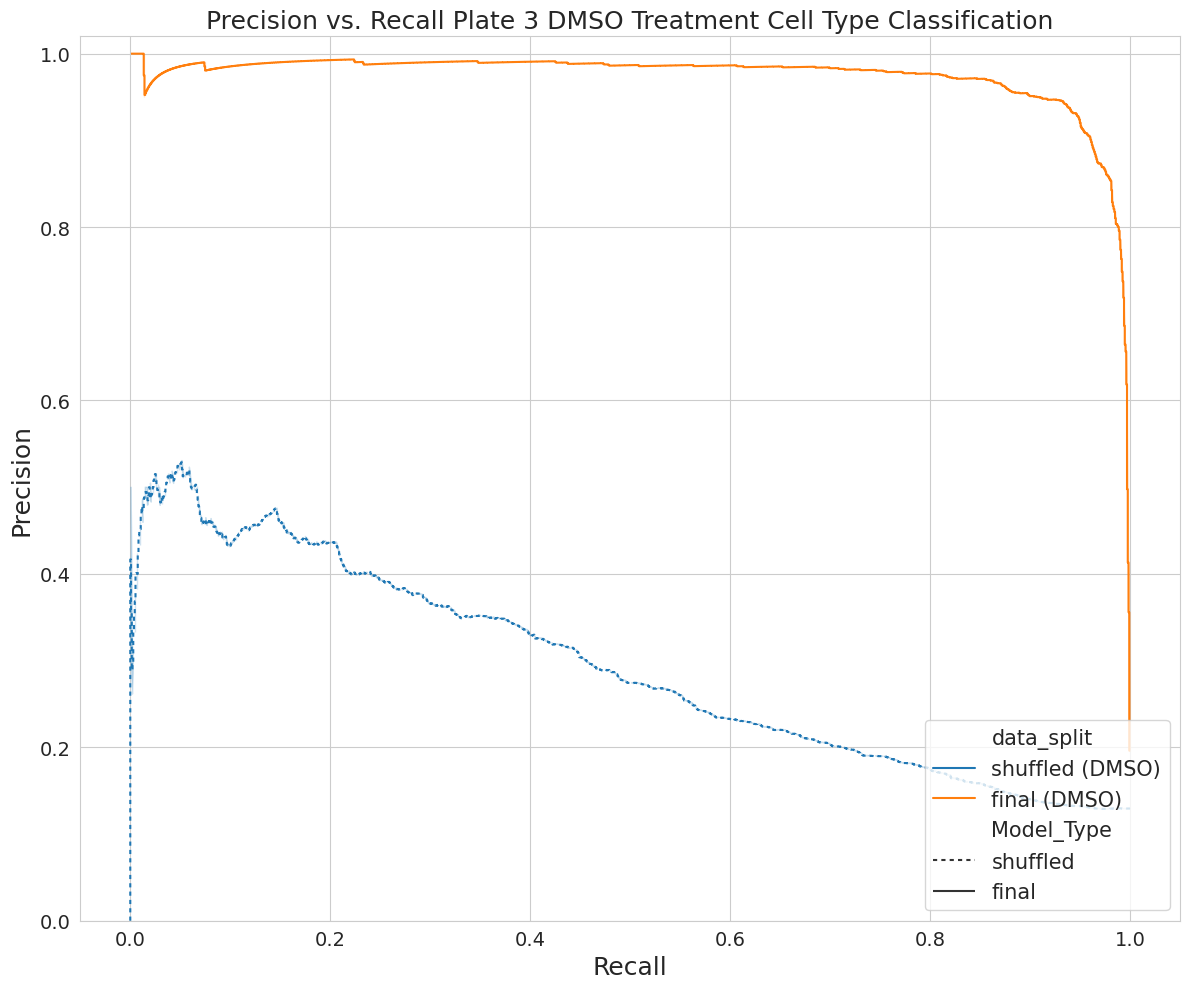

In [8]:
# PR curves with only testing and training data
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Combine model and data type as one column for plotting
pr_df["data_split"] = pr_df["Model_Type"] + " (" + pr_df["Data_Type"] + ")"

# Filter data frame to only show one data_type
filtered_df = pr_df[pr_df["Data_Type"].isin(["DMSO"])]

sns.lineplot(
    x="Recall",
    y="Precision",
    hue="data_split",
    style="Model_Type",
    dashes={"final": (1, 0), "shuffled": (2, 2)},
    drawstyle='steps',
    data=filtered_df,
)

plt.legend(loc="lower right", fontsize=15)
plt.ylim(bottom=0.0, top=1.02)
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.title("Precision vs. Recall Plate 3 DMSO Treatment Cell Type Classification", fontsize=18)

# Adjust x-axis ticks font size
plt.xticks(fontsize=14)

# Adjust y-axis ticks font size and labels
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(f"{fig_dir}/precision_recall_plate3_DMSO_only.png", dpi=500)

plt.show()

## Extract final model predicted probabilities for each treatment

In [9]:
# Create an empty DataFrame to store the results
combined_prob_df = pd.DataFrame()

for model_path in models_dir.iterdir():
    model_type = model_path.stem.split("_")[5]  # Get the model type
    
    for data, info in plate_3_dfs_dict.items():
        # Ensure that the file is named the correct data split
        data_split = data
        print(f"Extracting {model_type} probabilities from {data} data...")

        # Load in model to apply to datasets
        model = load(model_path)

        # Load in label encoder
        le = load(
            pathlib.Path("./encoder_results/label_encoder_log_reg_fs_plate_4.joblib")
        )

        # Get unique cell types and their corresponding encoded values
        unique_labels = le.classes_
        encoded_values = le.transform(unique_labels)

        # Create a dictionary mapping encoded values to original labels
        label_dict = dict(zip(encoded_values, unique_labels))

        # Load in data frame associated with the data split
        data_df = info["data_df"].reset_index(drop=True)

        # Load in X data to get predicted probabilities
        X, _ = get_X_y_data(df=data_df, label="Metadata_cell_type")

        # Predict class probabilities for morphology feature data
        predicted_probs = model.predict_proba(X)

        # Storing probabilities in a pandas DataFrame
        prob_df = pd.DataFrame(predicted_probs, columns=model.classes_)

        # Update column names in prob_df using the dictionary and add suffix "_probas"
        prob_df.columns = [label_dict[col] + '_probas' for col in prob_df.columns]

        # Add a new column called predicted_label for each row
        prob_df['predicted_label'] = prob_df.apply(lambda row: row.idxmax()[:-7], axis=1)

        # Select metadata columns from the data
        metadata_columns = data_df.filter(like='Metadata_')

        # Combine metadata columns with predicted probabilities DataFrame based on index
        prob_df = prob_df.join(metadata_columns)
        
        # Add a new column for model_type
        prob_df['model_type'] = model_type
        
        # Append the probability DataFrame to the combined DataFrame
        combined_prob_df = pd.concat([combined_prob_df, prob_df], ignore_index=True)

# Save combined prob data
combined_prob_df.to_csv(f"{prob_dir}/combined_plate_3_predicted_proba.csv", index=False)


Extracting shuffled probabilities from DMSO data...
Extracting shuffled probabilities from drug_x data...
Extracting shuffled probabilities from TGFRi data...
Extracting final probabilities from DMSO data...
Extracting final probabilities from drug_x data...
Extracting final probabilities from TGFRi data...
